<a href="https://colab.research.google.com/github/MMoltira/Chest-X-Ray-classification/blob/main/b1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
import pickle
import joblib

######Load data // KKUmail

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/Senior Project/CXR Image3class/Image'

train 3 class

In [6]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

######Load data // Gmail

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = '/content/drive/My Drive/Senior Project/Senior Project/CXR Image3class/Image'

train 3 class

In [10]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### train 3 class  
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 450 ภาพ TB150, Normal151 (เอามาแค่150) และ CA150 (CA คือ lungcancer)

In [11]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [12]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [13]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [14]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [15]:
data_train3 = pd.concat([tnormal[:-1], ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType,NumberType
147,ca88.jpg,Lungcancer,2
148,ca85.jpg,Lungcancer,2
149,ca94.jpg,Lungcancer,2


# K-fold 0-100
แก้เป็น k-fold หมดแล้ว 
เหลือลองรันว่าจะเจ้งมั้ย
- 311 layer
-   filepath มี .h5 ทุกอัน

### 8 


#### 8  soft pre bi


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

In [ ]:
H_Incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

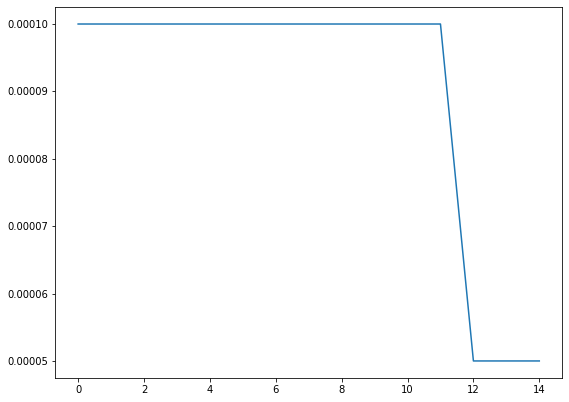

In [ ]:
lr = H_Incep.history['lr']

plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(lr, label = " Learning rate")

#### 8 soft pre bi adam  


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_bi_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 8 soft pre bi sgd  


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_bi_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_bi_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 8 soft pre cate 


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:10<00:00, 41.72it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_cate{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 8 soft pre cate adam


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_cate_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_cate_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 8 soft pre cate sgd


In [ ]:
BS = 8
filepath = "Kmodel8_soft_pre_cate_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:15<00:00, 28.30it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel8_soft_pre_cate_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.2917
Epoch 1: val_accuracy improved from -inf to 0.32222, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 82s 2s/step - loss: 1.1543 - accuracy: 0.2917 - val_loss: 1.1798 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.3028
Epoch 2: val_accuracy improved from 0.32222 to 0.35556, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 54s 1s/step - loss: 1.1319 - accuracy: 0.3028 - val_loss: 1.1130 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 1.1151 - accuracy: 0.3333
Epoch 3: val_accuracy improved from 0.35556 to 0.37778, saving

### 16


#### 16  soft pre bi


In [ ]:
BS = 16
filepath = "Kmodel16_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 16 soft pre bi adam  


In [ ]:
BS = 16
filepath = "Kmodel16_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_bi_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 16 soft pre bi sgd  


In [ ]:
BS = 16
filepath = "Kmodel16_soft_pre_bi_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:50<00:00,  4.08it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_bi_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

87924736/87910968 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.7646 - accuracy: 0.3634
Epoch 1: val_accuracy improved from -inf to 0.34444, saving model to  Kmodel16_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi_sgd1.h5 /assets
22/22 [==============================] - 72s 3s/step - loss: 0.7646 - accuracy: 0.3634 - val_loss: 0.7279 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.3372
Epoch 2: val_accuracy did not improve from 0.34444
22/22 [==============================] - 11s 478ms/step - loss: 0.7555 - accuracy: 0.3372 - val_loss: 0.7234 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.3576
Epoch 3: val_accuracy did not improve from 0.34444
22/22 [==============================] - 11s 471ms/step - loss: 0.7471 -

#### 16 soft pre cate 


In [ ]:
BS = 16
filepath = "Kmodel16_soft_pre_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_cate{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

87924736/87910968 [==============================] - 3s 0us/step
Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.6657
Epoch 1: val_accuracy improved from -inf to 0.43333, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 106s 3s/step - loss: 0.7561 - accuracy: 0.6657 - val_loss: 1.4739 - val_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8401
Epoch 2: val_accuracy improved from 0.43333 to 0.46667, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 49s 2s/step - loss: 0.4257 - accuracy: 0.8401 - val_loss: 1.7103 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8488
Epoch 3:

####16 soft pre cate adam


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:11<00:00, 38.62it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_cate_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.7811 - accuracy: 0.6512
Epoch 1: val_accuracy improved from -inf to 0.41111, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets
22/22 [==============================] - 71s 3s/step - loss: 0.7811 - accuracy: 0.6512 - val_loss: 1.4843 - val_accuracy: 0.4111 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8227
Epoch 2: val_accuracy improved from 0.41111 to 0.60000, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets
22/22 [==============================] - 50s 2s/step - loss: 0.4689 - accuracy: 0.8227 - val_loss: 0.9592 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8605
Epoch 3: val_accuracy improved from 0.60000 to 0.61111

#### 16 soft pre cate sgd


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:11<00:00, 38.52it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel16_soft_pre_cate_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.1706 - accuracy: 0.3140
Epoch 1: val_accuracy improved from -inf to 0.35556, saving model to  Kmodel16_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_sgd1.h5 /assets
22/22 [==============================] - 57s 2s/step - loss: 1.1706 - accuracy: 0.3140 - val_loss: 1.1708 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.1396 - accuracy: 0.3663
Epoch 2: val_accuracy did not improve from 0.35556
22/22 [==============================] - 11s 486ms/step - loss: 1.1396 - accuracy: 0.3663 - val_loss: 1.1458 - val_accuracy: 0.2889 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.3285
Epoch 3: val_accuracy did not improve from 0.35556
22/22 [==============================] - 11s 484ms/step - loss: 1.1336 - accuracy: 0.3285 - val_loss: 1.1415 - val_accuracy: 0.3444 -

### 32

#### 32  soft pre bi


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 32 soft pre bi adam  


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_bi_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 32 soft pre bi sgd  


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_bi_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_bi_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 32 soft pre cate 


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:10<00:00, 41.72it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_cate{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 32 soft pre cate adam


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_cate_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_cate_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 32 soft pre cate sgd


In [ ]:
BS = 32
filepath = "Kmodel32_soft_pre_cate_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel32_soft_pre_cate_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

### 1 


#### 1  soft pre bi


In [15]:
BS = 1
filepath = "Kmodel1_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:49<00:00,  4.11it/s]


In [16]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

87924736/87910968 [==============================] - 3s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.4528
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to  Kmodel1_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi1.h5 /assets
360/360 [==============================] - 122s 214ms/step - loss: 0.6104 - accuracy: 0.4528 - val_loss: 0.7491 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.5972
Epoch 2: val_accuracy improved from 0.30000 to 0.38889, saving model to  Kmodel1_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi1.h5 /assets
360/360 [==============================] - 68s 189ms/step - loss: 0.4744 - accuracy: 0.5972 - val_loss: 0.8039 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.6556
Epoc

#### 1 soft pre bi adam  


In [16]:
BS = 1
filepath = "Kmodel1_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:45<00:00,  4.26it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_bi_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

87924736/87910968 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.4361
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to  Kmodel1_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi_adam1.h5 /assets
360/360 [==============================] - 292s 791ms/step - loss: 0.6112 - accuracy: 0.4361 - val_loss: 0.4687 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.5833
Epoch 2: val_accuracy improved from 0.56667 to 0.63333, saving model to  Kmodel1_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi_adam1.h5 /assets
360/360 [==============================] - 303s 842ms/step - loss: 0.5024 - accuracy: 0.5833 - val_loss: 0.5502 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.4547 - 

#### 1 soft pre bi sgd  


In [ ]:
BS = 1
filepath = "Kmodel1_soft_pre_bi_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_bi_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 1 soft pre cate 


In [ ]:
BS = 1
filepath = "Kmodel1_soft_pre_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:10<00:00, 41.72it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_cate{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 1 soft pre cate adam


In [ ]:
BS = 1
filepath = "Kmodel1_soft_pre_cate_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_cate_adam{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))

#### 1 soft pre cate sgd


In [ ]:
BS = 1
filepath = "Kmodel1_soft_pre_cate_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Incep = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Incep.split(data_Incep):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" Kmodel1_soft_pre_cate_sgd{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Incep = data_Incep[train]
    y_train_Incep = labels_Incep[train]
    x_test_Incep = data_Incep[test]
    y_test_Incep = labels_Incep[test]

    H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Incep = model_Incep.predict(x_test_Incep)
    
    oos_y.append(y_test_Incep)
    oos_pred.append(pred_Incep)  
    print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1), oos_pred.argmax(axis=1),  target_names=le_Incep.classes_))